In [27]:
import numpy as np 
from scipy.stats import norm
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt 


# Markov Chains

A Markov chain is a sequence of random variables ${X^{(t)}}_{t=0}^{\infty}$, where each state $X^{(t)}$ belongs to a state space $\mathcal{S}$. Its defining feature, the Markov property, states that the next state depends only on the current state and not on past states. More formally,
$$
\mathbb{P}[X^{(t+1)} = j \mid X^{(t)} = i] = p_{i,j}^{(t)}
$$

where $p_{i,j}^{(t)}$ denotes the probability of moving from state $i$ to state $j$ at time $t+1$. Now if the Markov chain is irreducible (meaning any state can be reached from any other state) and aperiodic (it does not get "stuck" in cycles), then the distribution of $X^{(t)}$ will converge to a stationary distribution $\pi$ as $t$ grows large:

\begin{align*}
    \frac{1}{n} \sum_{t=1}^n h(X^{(t)}) \to \mathbb{E}_\pi[h(X)] \qquad \qquad (1.46)
\end{align*}

This stationary distribution is the target distribution we want to sample from. 

# Metrpolis Hasting 

Suppose we wanted to sample from a taget density $f$, defined as a mixture of two normals:
\begin{align*}
f(x)= \delta \mathcal{N}(\mu_1,\sigma_1)+(1−\delta)\mathcal{N}(\mu_2,\sigma_2)
\end{align*}
where $\mu_1 = 7$, $\mu_2 = 10$, $\sigma_1=\sigma_2 = \tfrac14$ and $\delta=0.7$. To apply the Metropolis-Hastings algorithm, we choose a proposal distribution given by a normal distribution centered at the current state:
\begin{align*}
g(x \mid x^{(t)}) = \mathcal{N}(x^{(t)}, 4) = \frac{1}{\sqrt{8\pi}} \exp\left( -\frac{(x - x^{(t)})^2}{8} \right).
\end{align*}
Then generate cadidate points $x^*$ from the proposal distribution that follow the below requirments

### Metropolis Hasting Algorithm

<div style="text-align: center;">
<img src="MH.png" alt="Hamiltonian Monte Carlo" width="500"/>
<\div>

In [13]:
#target density
def f(x, delta=0.7):
    return delta * norm.pdf(x, loc=7, scale=0.5) + (1 - delta) * norm.pdf(x, loc=10, scale=0.5)
#proposal distribution
def g(x, mu, sigma=2, pdf=False):
    if pdf:
        return norm.pdf(x, loc=mu, scale=sigma)  # Return density
    else:
        return np.random.normal(loc=mu, scale=sigma)  # Return a single sample

In [14]:
def MH_ratio(x, x_star):
    numerator = f(x_star) * g(x, mu=x_star, pdf=True)
    denominator = f(x) * g(x_star, mu=x, pdf=True)
    return numerator / denominator

In [59]:
def metropolis_hastings(x0, T=10000):
    x = np.zeros(T)       # Vector to store sample states
    x[0] = x0             # Initial value
    accept_count = 0      # Number of accepted states
    reject_count = 0      # Number of rejected states

    for t in range(T - 1):
        # Step 1: Generate a candidate x_star from the proposal distribution
        x_star = g(x[t],mu=x[t])  # Proposal centered at current value x[t]

        # Step 2: Calculate the Metropolis-Hastings acceptance ratio
        r = MH_ratio(x[t], x_star)

        # Step 3: Accept or Reject the candidate
        u = np.random.uniform()
        if r >= 1 or u < r:
            x[t + 1] = x_star
            accept_count += 1
        else:
            x[t + 1] = x[t]
            reject_count += 1

    acceptance_rate = accept_count / (T - 1)
    rejection_rate = reject_count / (T - 1)

    return {
        "samples": x,
        "acceptance_rate": acceptance_rate,
        "rejection_rate": rejection_rate
    }

In [68]:
x0 = 8.5
N = 10000
chain = metropolis_hastings(x0, N)
samples = chain["samples"]
x_vals = np.linspace(5, 12, 1000)

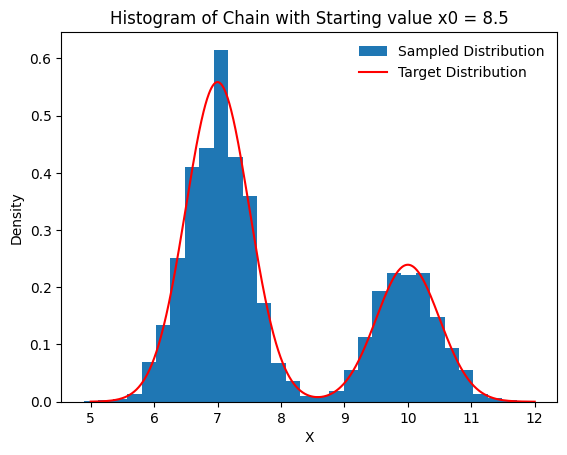

In [69]:
plt.hist(samples, bins=30, density=True, label='Sampled Distribution')
plt.plot(x_vals, f(x_vals), color='red', label='Target Distribution')            
plt.title("Histogram of Chain with Starting value x0 = 8.5")
plt.xlabel("X")
plt.ylabel("Density")
plt.legend(framealpha=0)
plt.show()

# Hamiltonian Monte Carlo

Expectations can be difficult to compute in higher dimensions. In general, there are $3^{D} - 1$ neighboring partitions in $D$-dimensional space. Hamiltonian Equations perserve "phase space", meaning that as the system evolves over time, the total volume of any region in phase space remains constant.

### Hamiltonian Equations

$$ H(p,q) = U(q) + K(p)$$
where $H(q,p)$, represents the total energy of the system. The function $U(q)$, captures the potential energy based on the current position $q$ , and $K(p)$, represents the kinetic energy based on the  current momentum $p$. 

Using a probabilistic framework, $q$ represents the parameters of the target density that we want to ultimately sample  from. And so if we let the function $U(q)$ represent the negative logarithm of the target density function, what we are effectively doing is transforming the target distribution into a scale where high-probability regions correspond to lower potential energy states. 

Now, it turns out that the probability distribution of the momentum term is related to Boltzmann distribution. In otherwords, 

\begin{align*}
\pi(p)\propto \exp(-K(p)) = \exp\left(-\tfrac12p^\prime M^{-1}p \right)
\end{align*}

where $M$ denotes a "mass matrix". Notice, by normalizing $\exp(-K(p))$:

\begin{align*}
\pi(p) = \frac{1}{\sqrt{(2\pi)^n |M|}} \exp\left( -\frac{1}{2} p^T M^{-1} p \right) \implies
f(p) = \frac{1}{\sqrt{(2\pi)^n |\Sigma|}} \exp\left( -\frac{1}{2} p^T \Sigma^{-1} p \right)
\end{align*}

which implies $p \sim MVN(0, \Sigma)$

### Hamiltonian Dynamics

$$ 
\frac{dq}{dt} = \frac{\partial H}{\partial p}, \quad \frac{dp}{dt} = - \frac{\partial H}{\partial q}
$$

Now most of the times these systems are intractable, therefore we have to rely on numerical methods to approximate them. A classical approach for solving such differential equations is Euler’s method:

$$ 
q_{t+1} = q_t + \Delta t \frac{\partial H}{\partial p}, \quad p_{t+1} = p_t  - \Delta t \frac{\partial H}{\partial q}
$$

### Euler's Method: Example

Let, 
$$ 
H(p,q) = \frac{q^2}{2} + \frac{p^2}{2} \implies \frac{dq}{dt} = \frac{\partial H}{\partial p} = p, \; \frac{dp}{dt} = - \frac{\partial H}{\partial q} = -q
$$

In [ ]:
def Eulers_Method(dt, steps, q_init, p_init):
    q_values = np.zeros(steps + 1)
    p_values = np.zeros(steps + 1)

    q_values[0] = q_init
    p_values[0] = p_init

    # Euler's Method
    for t in range(steps):
        q = q_values[t] + dt * p_values[t]
        p = p_values[t] - dt * q_values[t]
        q_values[t + 1] = q
        p_values[t + 1] = p

    return q_values, p_values

In [34]:
q1, p1 = Eulers_Method(dt=0.3, steps=20, q_init=0, p_init=1)
q2, p2 = Eulers_Method(dt=0.1, steps=60, q_init=0, p_init=1)

time_points_2 = np.linspace(0, 100 * 0.1, num=200)
q_true = np.sin(time_points_2)
p_true = np.cos(time_points_2)

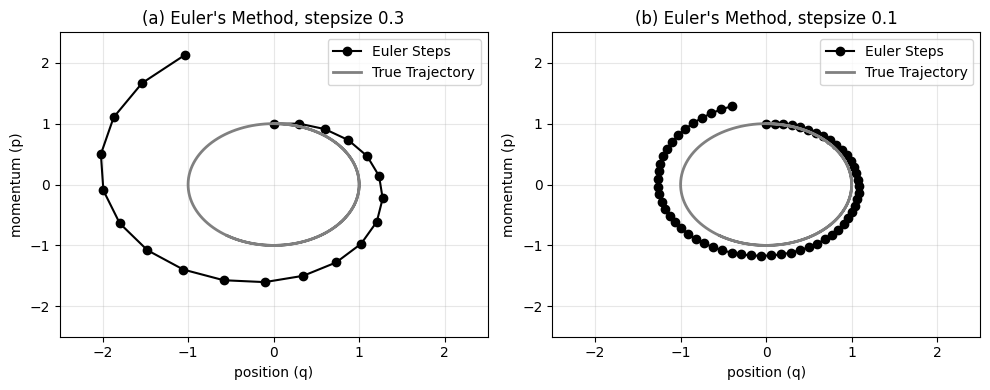

In [35]:
# Plot (a) Euler's Method, stepsize 0.3
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(q1, p1, 'o-', color='black', label="Euler Steps")
plt.plot(q_true, p_true, color='gray', linewidth=2, label="True Trajectory")
plt.xlabel("position (q)")
plt.ylabel("momentum (p)")
plt.title("(a) Euler's Method, stepsize 0.3")
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.grid(alpha=0.3)
plt.legend()

# Plot (b) Euler's Method, stepsize 0.1
plt.subplot(1, 2, 2)
plt.plot(q2, p2, 'o-', color='black', label="Euler Steps")
plt.plot(q_true, p_true, color='gray', linewidth=2, label="True Trajectory")
plt.xlabel("position (q)")
plt.ylabel("momentum (p)")
plt.title("(b) Euler's Method, stepsize 0.1")
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.grid(alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

Notice that Euler’s method gradually deviates from the true trajectory. This happens because it is not time-reversible—reversing the simulation does not return the system to its initial state. Moreover, Euler’s method is not symplectic, meaning it fails to preserve the system’s geometric structure. As a result, small numerical errors accumulate over time, producing the spiraling drift observed in the plot.

### Leapfrog Method

To address this issue we can implement the Leapfrog Method, which staggers the updates:
$$ 
p_{t+ \tfrac12} = p_t  - \frac{\Delta t}{2} q_t \\
q_{t+1} = q_t + \Delta t  \cdot p_{t + \tfrac12} \\ 
p_{t + \tfrac12} = p_{t + \tfrac12} - \frac{\Delta t}{2} \cdot q_{t + 1}
$$

In [36]:
def leapfrog_method(dt, steps, q_init, p_init):
    q_values = np.zeros(steps + 1)
    p_values = np.zeros(steps + 1)

    q_values[0] = q_init
    p_values[0] = p_init

    # Leapfrog Method
    for t in range(steps):
        p_half = p_values[t] - 0.5 * dt * q_values[t]
        q = q_values[t] + dt * p_half
        p = p_half - 0.5 * dt * q
        q_values[t + 1] = q
        p_values[t + 1] = p

    return q_values, p_values

In [37]:
q1, p1 = leapfrog_method(dt=0.3, steps=20, q_init=0, p_init=1)
q2, p2 = leapfrog_method(dt=0.1, steps=60, q_init=0, p_init=1)

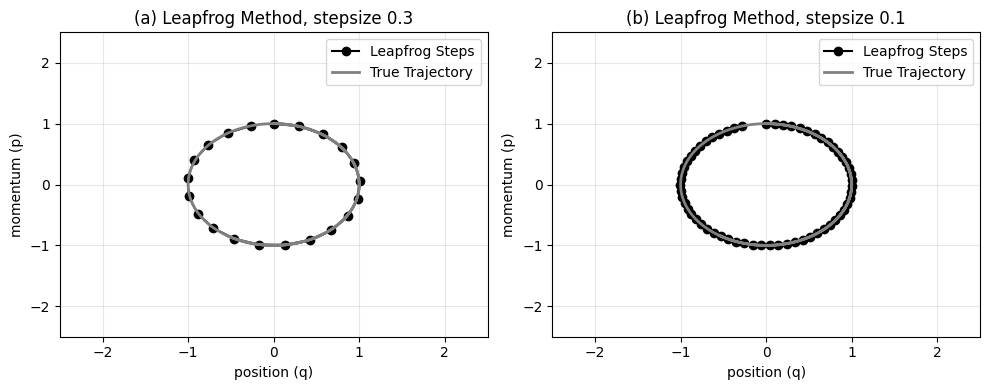

In [38]:
# Plot (a) Leapfrog Method, stepsize 0.3
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(q1, p1, 'o-', color='black', label="Leapfrog Steps")
plt.plot(q_true, p_true, color='gray', linewidth=2, label="True Trajectory")
plt.xlabel("position (q)")
plt.ylabel("momentum (p)")
plt.title("(a) Leapfrog Method, stepsize 0.3")
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.grid(alpha=0.3)
plt.legend()

# Plot (b) Leapfrog Method, stepsize 0.1
plt.subplot(1, 2, 2)
plt.plot(q2, p2, 'o-', color='black', label="Leapfrog Steps")
plt.plot(q_true, p_true, color='gray', linewidth=2, label="True Trajectory")
plt.xlabel("position (q)")
plt.ylabel("momentum (p)")
plt.title("(b) Leapfrog Method, stepsize 0.1")
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.grid(alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# Hamilton Monte Carlo Algorithm

<div style="text-align: center;">
<img src="HMC.png" alt="Hamiltonian Monte Carlo" width="500"/>
<\div>

In [40]:
from scipy.optimize import approx_fprime

# Numerical gradient of U
def grad_U(U, x, epsilon=1e-5):
    return approx_fprime(x, U, epsilon)

# Hamiltonian Monte Carlo step
def HMC(U, K, delta_t, L, q_init):
    #1. Initialize x, and momentum p sampled from a standard normal distribution
    x = np.copy(q_init)
    p = np.random.normal(0, 1, size=x.shape)
    p_init = np.copy(p)

    #2. Leapfrog integration
    for _ in range(L):
        p -= (delta_t / 2) * grad_U(U, x)
        x += delta_t * p
        p -= (delta_t / 2) * grad_U(U, x)

    #3. Compute Hamiltonians
    H_initial = U(q_init) + K(p_init)
    H_proposed = U(x) + K(p)

    #4. Acceptance probability
    alpha = min(1, np.exp(H_initial - H_proposed))
    u = np.random.uniform()

    if u < alpha:
        return {"state": x, "accepted": True}
    else:
        return {"state": q_init, "accepted": False}

In [43]:
# Target density
def f(x, delta=0.7):
    return delta * norm.pdf(x, loc=7, scale=0.5) + (1 - delta) * norm.pdf(x, loc=10, scale=0.5)

def U(x, delta=0.7):
    """Potential energy function"""
    density = f(x, delta)
    return -np.log(density)

import numpy as np

def K(p):
    """
    Kinetic energy function with identity mass matrix.
    K(p) = 0.5 * p.T @ I @ p = 0.5 * p.T @ p
    """
    p = np.asarray(p)
    kinetic_energy = 0.5 * np.dot(p, p) 
    return float(kinetic_energy)

In [52]:

n_samples = 1000
delta_t = 0.1
L = 10
q_0 = np.array([8.5])  
samples = np.zeros((n_samples, len(q_0)))
samples[0] = q_0
accepted_count = 0

for i in range(n_samples - 1):
    result = HMC(U, K, delta_t, L, samples[i])
    next_state = result["state"]
    accepted = result["accepted"]

    samples[i + 1] = next_state

    if accepted:
        accepted_count += 1

acceptance_rate = accepted_count / n_samples
rejection_rate = 1 - acceptance_rate

print(f"Acceptance Rate: {acceptance_rate:.4f}")
print(f"Rejection Rate: {rejection_rate:.4f}")

Acceptance Rate: 0.9950
Rejection Rate: 0.0050


In [53]:
samples.shape

(1000, 1)

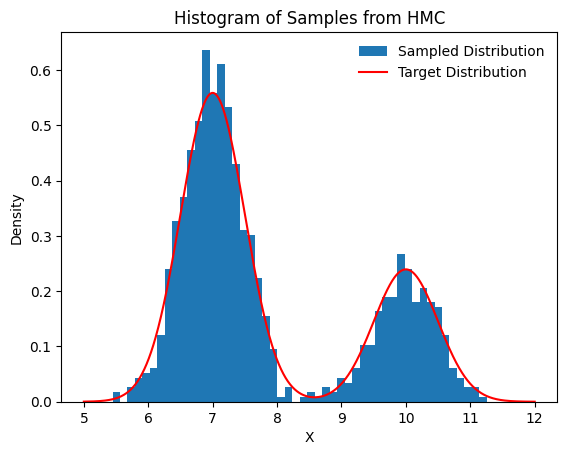

In [57]:
plt.hist(samples, bins=50, density=True, label='Sampled Distribution');
plt.plot(x_vals, f(x_vals), color='red', label='Target Distribution')
plt.title("Histogram of Samples from HMC")
plt.xlabel("X")
plt.ylabel("Density")
plt.legend(framealpha=0)
plt.show()